In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps" if not torch.cuda.is_available() else "cuda"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)
model = model.to(device)
model.eval()

# Load tokenizer 
# (1). base tokenizer
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

# (2). input tokenizer
# if 'tokenizer_path' in checkpoint: 
#     tok = ETokenizer.load(checkpoint["tokenizer_path"])
# else: 
#     tok = base_tok.copy()

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_33539/17962131.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location

number of parameters: 10.66M


baseline LM bpc: 1.6985

Tokenizer Encoding speed optimisation 

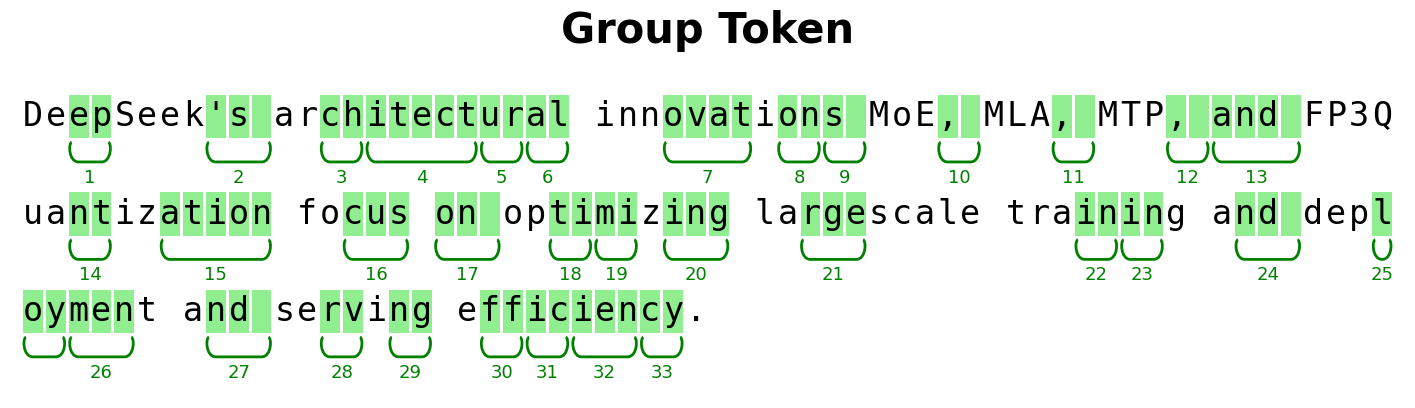

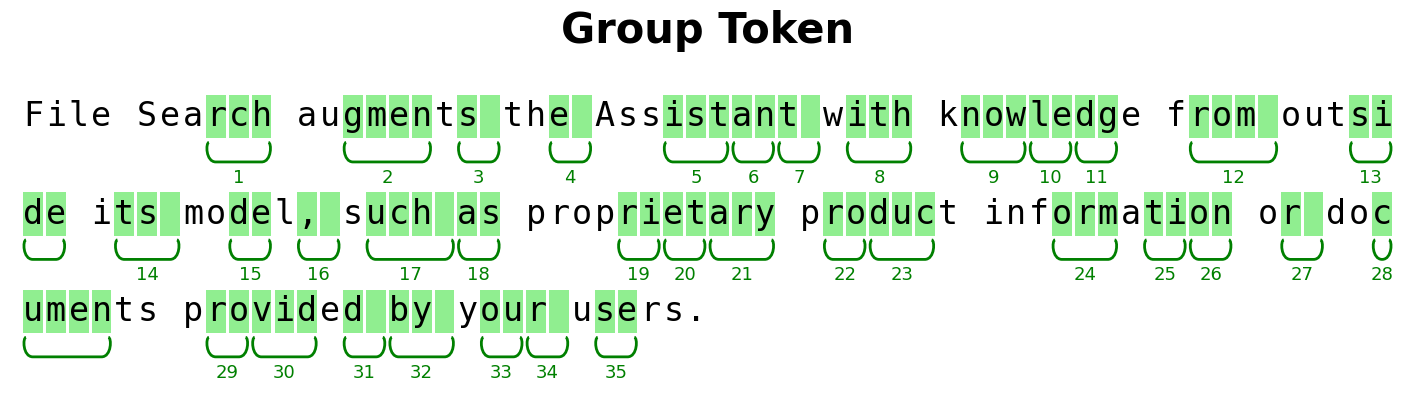

In [2]:
from magicab import Magicab

magicab = Magicab(model, 
                  tokenizer=tok, # input tokenizer
                  checkpoint_dir="checkpoint/base", spike_perplexity_threshold=5.0, group_perplexity_threshold=0.3)

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [3]:
magicab.cache_vocab_change(text=texts)
magicab.update_vocab(max_size_change=1000)

 - Group token detection took: 0.0005 seconds
   :: add_tokens: 0.0002 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0021 seconds
   :: slice_embeddings: per input row  0.0011 seconds
   :: update_token_addition: 0.0000 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0002 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.0026 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.0321 seconds
:: Total 58 token groups, added 92 pairwise merges
:: Total 92 new tokens added
Function add_to_vocab took 0.0130 seconds
 - add_to_vocab done


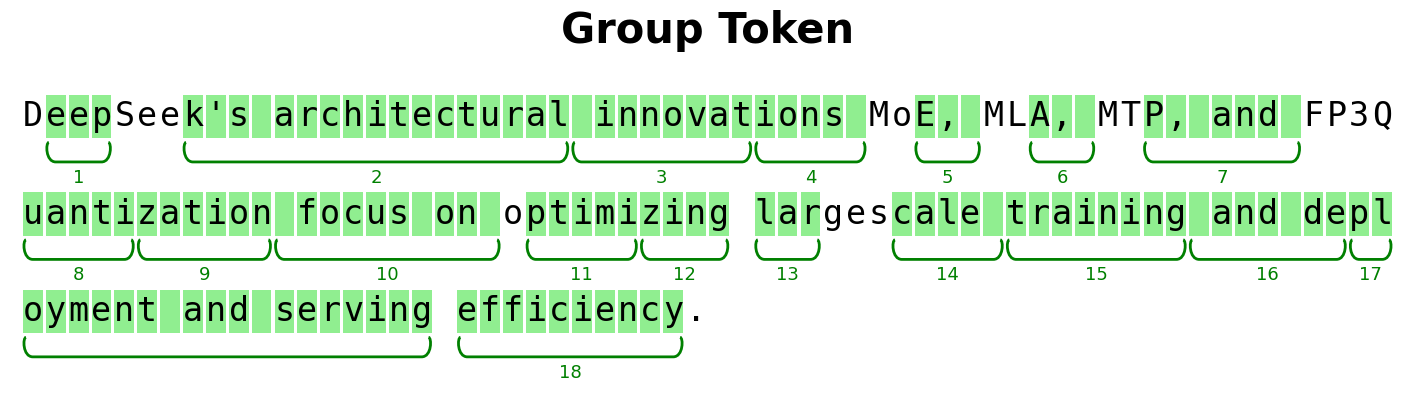

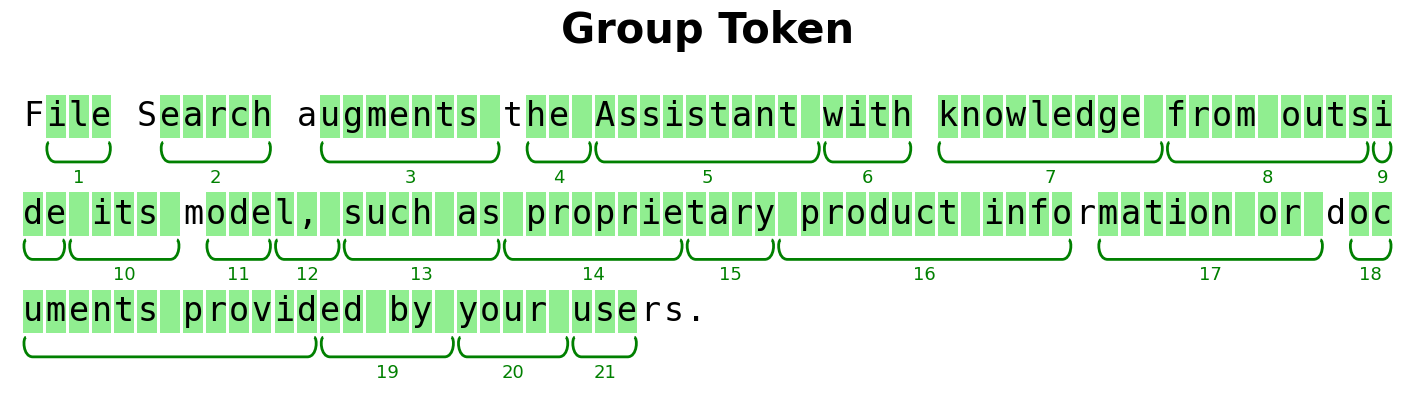

In [7]:
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [29]:
from magicab import save_magicab 
save_magicab(checkpoint, magicab, out_dir="checkpoint/try4") # fine now

num decayed parameter tensors: 27, with 10,960,128 parameters
num non-decayed parameter tensors: 13, with 4,992 parameters
using fused AdamW: False


In [3]:
# base BPE tokenizer (how to train it?)
from magicab.base_tok import BasicTokenizer

basetok = BasicTokenizer()

In [4]:
import pickle
import glob 

pkl_paths = "checkpoint/run1/*.pkl"
vocab_sizes = []
bpcs = []
for pkl_path in glob.glob(pkl_paths):
    with open(pkl_path, "rb") as f:
        info = pickle.load(f)
        vocab_size = info["config"]["vocab_size"]
        bpc = info["bpc"].item()
    vocab_sizes.append(vocab_size)
    bpcs.append(bpc)

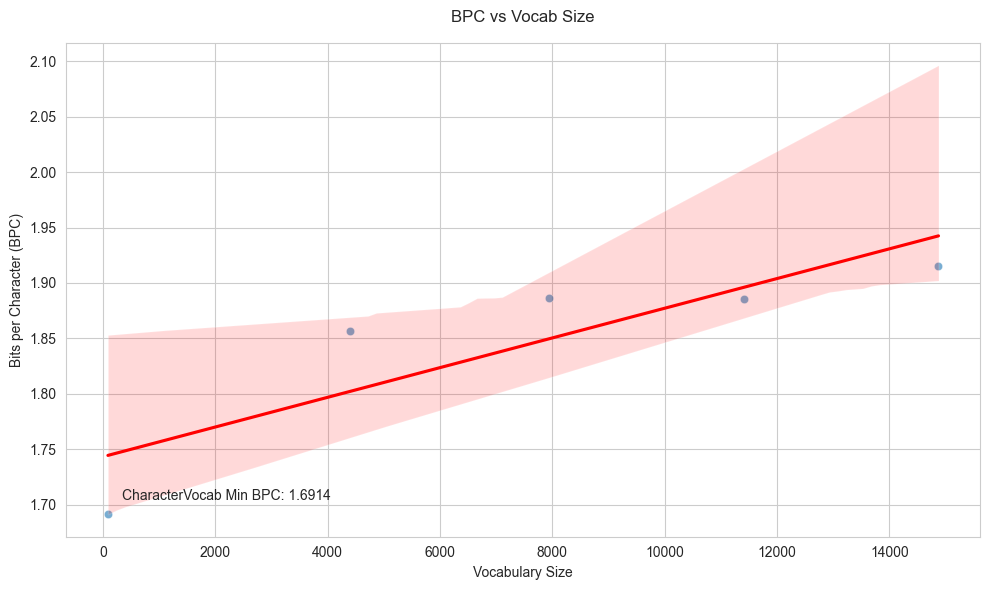

In [3]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for better plotting
df = pd.DataFrame({
    'Vocabulary Size': vocab_sizes,
    'Bits per Character': bpcs
})

# Set the style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Vocabulary Size', y='Bits per Character', alpha=0.6)
sns.regplot(data=df, x='Vocabulary Size', y='Bits per Character', scatter=False, color='red')

# Customize the plot
plt.title('BPC vs Vocab Size', pad=15)
plt.xlabel('Vocabulary Size')
plt.ylabel('Bits per Character (BPC)')

# Add annotations
plt.annotate(f'CharacterVocab Min BPC: {min(bpcs):.4f}', 
            xy=(vocab_sizes[bpcs.index(min(bpcs))], min(bpcs)),
            xytext=(10, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

In [5]:
info['config']['vocab_size']

14872

In [5]:
from data.enwiki.util import prepare_enwiki_data
from magicab import update_magicab
from magicab.magicab import get_batch
import time 

# Update data with tokenizer (11min --> 40s with rust tokenization)
# t0 = time.time()
# prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 
# t1 = time.time()
# print("Time taken to update data: ", t1 - t0)

In [6]:
data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "mps" if not torch.cuda.is_available() else "cuda"
max_size_change = 2000

update_magicab(magicab, data_dir, block_size, batch_size, device_type, max_size_change)

Updating Magicab Vocabulary:   0%|          | 0/763 [00:00<?, ?it/s]

   :: Remove token mask calculation: 0.1393 seconds
   :: Remove token list appending loop: 0.0509 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1918 seconds
 - Group token detection took: 0.0550 seconds


Updating Magicab Vocabulary:   0%|          | 1/763 [00:02<27:33,  2.17s/it]

   :: add_tokens: 0.0130 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1034 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0817 seconds
   :: update_caches: per input row  0.0003 seconds
 - Vocabulary addition prep took: 0.2021 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 2.1630 seconds
   :: Remove token mask calculation: 0.0637 seconds
   :: Remove token list appending loop: 0.0538 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1176 seconds
 - Group token detection took: 0.0482 seconds
   :: add_tokens: 0.0169 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0721 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_add

Updating Magicab Vocabulary:   0%|          | 2/763 [00:03<20:09,  1.59s/it]

 - Cache updates took: 0.0148 seconds
Function _cache_vocabulary_change took 1.1757 seconds


Updating Magicab Vocabulary:   0%|          | 3/763 [00:04<17:35,  1.39s/it]

   :: Remove token mask calculation: 0.0587 seconds
   :: Remove token list appending loop: 0.0515 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1103 seconds
 - Group token detection took: 0.0480 seconds
   :: add_tokens: 0.0201 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0647 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0022 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0900 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0077 seconds
Function _cache_vocabulary_change took 1.1457 seconds
   :: Remove token mask calculation: 0.0580 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0

Updating Magicab Vocabulary:   1%|          | 4/763 [00:05<16:37,  1.31s/it]

   :: add_tokens: 0.0217 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0640 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0021 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0907 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0086 seconds
Function _cache_vocabulary_change took 1.1948 seconds


Updating Magicab Vocabulary:   1%|          | 5/763 [00:06<15:46,  1.25s/it]

   :: Remove token mask calculation: 0.0579 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1088 seconds
 - Group token detection took: 0.0479 seconds
   :: add_tokens: 0.0227 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0500 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0017 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0769 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0076 seconds
Function _cache_vocabulary_change took 1.1297 seconds
   :: Remove token mask calculation: 0.0569 seconds
   :: Remove token list appending loop: 0.0519 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0

Updating Magicab Vocabulary:   1%|          | 6/763 [00:08<15:32,  1.23s/it]

   :: add_tokens: 0.0242 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0470 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0451 seconds
   :: update_caches: per input row  0.0002 seconds
 - Vocabulary addition prep took: 0.1190 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0069 seconds
Function _cache_vocabulary_change took 1.1961 seconds


Updating Magicab Vocabulary:   1%|          | 7/763 [00:09<15:08,  1.20s/it]

   :: Remove token mask calculation: 0.0582 seconds
   :: Remove token list appending loop: 0.0512 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1095 seconds
 - Group token detection took: 0.0482 seconds
   :: add_tokens: 0.0255 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0530 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0017 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0829 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0087 seconds
Function _cache_vocabulary_change took 1.1353 seconds
   :: Remove token mask calculation: 0.0590 seconds
   :: Remove token list appending loop: 0.0524 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0

Updating Magicab Vocabulary:   1%|          | 8/763 [00:10<14:58,  1.19s/it]

   :: add_tokens: 0.0259 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0515 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0016 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0818 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0075 seconds
Function _cache_vocabulary_change took 1.1606 seconds
   :: Remove token mask calculation: 0.0567 seconds
   :: Remove token list appending loop: 0.0526 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1096 seconds
 - Group token detection took: 0.0922 seconds


Updating Magicab Vocabulary:   1%|          | 9/763 [00:11<14:57,  1.19s/it]

   :: add_tokens: 0.0296 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0534 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0016 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0874 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0077 seconds
Function _cache_vocabulary_change took 1.1854 seconds


Updating Magicab Vocabulary:   1%|▏         | 10/763 [00:12<14:44,  1.17s/it]

   :: Remove token mask calculation: 0.0590 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1100 seconds
 - Group token detection took: 0.0495 seconds
   :: add_tokens: 0.0303 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0433 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0013 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0775 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0068 seconds
Function _cache_vocabulary_change took 1.1348 seconds


Updating Magicab Vocabulary:   1%|▏         | 11/763 [00:13<14:41,  1.17s/it]

   :: Remove token mask calculation: 0.0780 seconds
   :: Remove token list appending loop: 0.0540 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1322 seconds
 - Group token detection took: 0.0477 seconds
   :: add_tokens: 0.0322 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0499 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0015 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0864 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0079 seconds
Function _cache_vocabulary_change took 1.1643 seconds
   :: Remove token mask calculation: 0.0775 seconds
   :: Remove token list appending loop: 0.0575 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0

Updating Magicab Vocabulary:   2%|▏         | 12/763 [00:15<14:57,  1.20s/it]

   :: add_tokens: 0.0318 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0515 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0016 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0012 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0871 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0077 seconds
Function _cache_vocabulary_change took 1.2447 seconds


Updating Magicab Vocabulary:   2%|▏         | 13/763 [00:16<14:53,  1.19s/it]

   :: Remove token mask calculation: 0.0834 seconds
   :: Remove token list appending loop: 0.0551 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1386 seconds
 - Group token detection took: 0.0482 seconds
   :: add_tokens: 0.0322 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0456 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0014 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0819 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0083 seconds
Function _cache_vocabulary_change took 1.1764 seconds
   :: Remove token mask calculation: 0.0696 seconds
   :: Remove token list appending loop: 0.0538 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0

Updating Magicab Vocabulary:   2%|▏         | 14/763 [00:17<15:09,  1.21s/it]

 - Group token detection took: 0.1494 seconds
   :: add_tokens: 0.0337 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0534 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0014 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0914 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0079 seconds
Function _cache_vocabulary_change took 1.2650 seconds


Updating Magicab Vocabulary:   2%|▏         | 15/763 [00:18<15:01,  1.21s/it]

   :: Remove token mask calculation: 0.0735 seconds
   :: Remove token list appending loop: 0.0531 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1267 seconds
 - Group token detection took: 0.0477 seconds
   :: add_tokens: 0.0384 seconds
   :: add_tokens: per input row  0.0002 seconds
   :: slice_embeddings: 0.0464 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0015 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0891 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0088 seconds
Function _cache_vocabulary_change took 1.1814 seconds


Updating Magicab Vocabulary:   2%|▏         | 16/763 [00:19<14:43,  1.18s/it]

   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0511 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0466 seconds
   :: add_tokens: 0.0347 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0392 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0015 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0011 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0775 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0066 seconds
Function _cache_vocabulary_change took 1.1253 seconds
   :: Remove token mask calculation: 0.0594 seconds
   :: Remove token list appending loop: 0.0525 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0

Updating Magicab Vocabulary:   2%|▏         | 17/763 [00:21<14:48,  1.19s/it]

   :: add_tokens: 0.0379 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0472 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0013 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0893 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0066 seconds
Function _cache_vocabulary_change took 1.2080 seconds
   :: Remove token mask calculation: 0.0670 seconds
   :: Remove token list appending loop: 0.0806 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1478 seconds
 - Group token detection took: 0.0488 seconds


Updating Magicab Vocabulary:   2%|▏         | 18/763 [00:22<14:46,  1.19s/it]

   :: add_tokens: 0.0389 seconds
   :: add_tokens: per input row  0.0002 seconds
   :: slice_embeddings: 0.0419 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0011 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0846 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0074 seconds
Function _cache_vocabulary_change took 1.1812 seconds


Updating Magicab Vocabulary:   2%|▏         | 19/763 [00:23<14:37,  1.18s/it]

   :: Remove token mask calculation: 0.0698 seconds
   :: Remove token list appending loop: 0.0525 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1224 seconds
 - Group token detection took: 0.0473 seconds
   :: add_tokens: 0.0392 seconds
   :: add_tokens: per input row  0.0002 seconds
   :: slice_embeddings: 0.0392 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0016 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0009 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0819 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0063 seconds
Function _cache_vocabulary_change took 1.1530 seconds
   :: Remove token mask calculation: 0.0698 seconds
   :: Remove token list appending loop: 0.0543 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0

Updating Magicab Vocabulary:   3%|▎         | 20/763 [00:24<14:50,  1.20s/it]

   :: add_tokens: 0.0587 seconds
   :: add_tokens: per input row  0.0002 seconds
   :: slice_embeddings: 0.0523 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0022 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0017 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.1165 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0062 seconds
Function _cache_vocabulary_change took 1.2392 seconds


Updating Magicab Vocabulary:   3%|▎         | 21/763 [00:25<14:43,  1.19s/it]

   :: Remove token mask calculation: 0.0795 seconds
   :: Remove token list appending loop: 0.0522 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1318 seconds
 - Group token detection took: 0.0481 seconds
   :: add_tokens: 0.0399 seconds
   :: add_tokens: per input row  0.0002 seconds
   :: slice_embeddings: 0.0411 seconds
   :: slice_embeddings: per input row  0.0002 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0013 seconds
   :: update_caches: per input row  0.0000 seconds
 - Vocabulary addition prep took: 0.0849 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0060 seconds
Function _cache_vocabulary_change took 1.1693 seconds


Updating Magicab Vocabulary:   3%|▎         | 21/763 [00:26<15:46,  1.28s/it]

   :: Remove token mask calculation: 0.0750 seconds


KeyboardInterrupt: 

In [8]:
magicab.tokenizer.vocab_size

92